In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import gpytorch
from sklearn.preprocessing import MinMaxScaler
plt.rcParams.update({'figure.figsize':(15,12), 'figure.dpi':120})

In [17]:
base_data = pd.read_csv('data.csv', index_col=0)
base_data.index = pd.to_datetime(base_data.index)
base_data = base_data.asfreq('H')

imputed_data = base_data.copy()
for idx, row in imputed_data.iterrows():
    if np.isnan(row.tmp_f_KDFW):
        imputed_data.loc[idx].tmp_f_KDFW = base_data[
                                                    (base_data.index.month == idx.month) & 
                                                    (base_data.index.day == idx.day) & 
                                                    (base_data.index.hour == idx.hour)
                                                ].tmp_f_KDFW.mean()
        
obs_data = imputed_data[imputed_data.index < '2021-07-01']
obs_data = obs_data.asfreq('H')

scaler = MinMaxScaler()
scaler.fit(obs_data[['tmp_f_KDFW', 'north_load']])
imputed_data[['tmp_f_KDFW', 'north_load']] = scaler.transform(imputed_data)

imputed_data.fillna(0, inplace=True)

In [45]:
train_X_time_delta = imputed_data[:'2021-06-30'].index.to_pydatetime() - min(imputed_data.index.to_pydatetime())
train_x = torch.Tensor([train_X_time_delta[i].total_seconds() for i in range(train_X_time_delta.shape[0])])

In [46]:
train_y = torch.Tensor(imputed_data[:'2021-06-30'].north_load)

In [47]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [48]:
model.train()

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [49]:
likelihood.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [50]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [51]:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [ ]:
training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

In [1]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

NameError: name 'model' is not defined

In [15]:
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size((1000,)))

/home/esherma9/miniconda3/envs/NT_Demand/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/esherma9/miniconda3/envs/NT_Demand/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


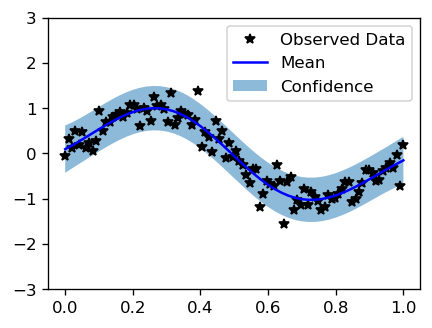

In [16]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])